# Summarization

In this notebook we go through the task of summarization. We explore how we can leverage pre-trained tranformers to summarize documents. Summarization is a seq2seq task with an input and a target text (this is where encoder-decoder transformers excel). 

## CNN/DailyMail dataset

300k pairs of news articles and their correspnding summaries. These are abstractive and not extractive (contains new sentences not simple excerpts). 

In [14]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
dataset['train'].column_names

['article', 'highlights', 'id']

In [15]:
# Let's look at an except from an acrticle

sample = dataset['train'][2]
print(f"""
Article: excerpt of 500 char, total lenght: {len(sample['article'])}
""")
print(sample['article'][:500])
print(f"/nSummary: lenght: {len(sample['highlights'])}")
print(sample['highlights'])


Article: excerpt of 500 char, total lenght: 3940

MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. "The whole bridge from one side of the Mississippi to the other just completely gave way, fell all the way down," survivor Gary Babineau told CNN. "I probably had a 30-, 35-foot free fall. And there's cars in the water, there's cars on fire. The whole bridge is down." He said his back was injured but he determined he could move around. "I realized there was a school bus 
/nSummary: lenght: 224
NEW: "I thought I was going to die," driver says .
Man says pickup truck was folded in half; he just has cut on face .
Driver: "I probably had a 30-, 35-foot free fall"
Minnesota bridge collapsed during rush hour Wednesday .


## Text Summarization pipelines

In [16]:
sample_text = dataset['train'][2]["article"][:2000]
summaries = {}


# NLTK includes a algo to detect the diff between end of sentence and end of abbr (eg. U.N. vs sentence end)

import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
string =  "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

# Common basaline for summarization is to use the first 3 sentences of the article

def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries['baseline'] = three_sentence_summary(sample_text)


[nltk_data] Downloading package punkt to /home/nurbot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# GPT-2 can be used for summarization if we append TL;DR
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = sample_text + "\nTL;DR:"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries['gpt2'] = "\n".join(
    sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query):]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [18]:
# T5 is a transformer trained on summarization task
# The checkpoints can be used directly to perform summarization if we use the same prompt as the training data
# summarize: <ARTICLE>
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries['t5'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

/home/nurbot/miniconda3/envs/hf/lib/python3.11/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [19]:
# BART is also encoder-decoder transformer trained on summarization task
# we use a checkpoint that has been specifically trained on CNN/DailyMail dataset
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries['bart'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

In [20]:
# PEASUS which pretraining objective was to predict masekd sentences in multisentence text
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries['pegasus'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Let's compare!

print("Baseline:\n")
print(dataset["train"][2]["highlights"])
print("\n")

for model_name in summaries:
    print(f"{model_name.upper()}:\n")
    print(summaries[model_name])
    print("\n")

Baseline:

NEW: "I thought I was going to die," driver says .
Man says pickup truck was folded in half; he just has cut on face .
Driver: "I probably had a 30-, 35-foot free fall"
Minnesota bridge collapsed during rush hour Wednesday .


BASELINE:

MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival.
"The whole bridge from one side of the Mississippi to the other just completely gave way, fell all the way down," survivor Gary Babineau told CNN.
"I probably had a 30-, 35-foot free fall.


GPT2:

 You have to be a real tough little human to drive 100 feet to the north of this bridge (on a bridge which spans 40 miles).
After two hours and six deaths and two broken legs and still not completely clear of a death, just a few feet from I-55 is my favorite


T5:

"i probably had a 30-, 35-foot free fall," survivor Gary Babineau tells CNN .
emergency room physician rushed to the scene in 15 minutes .
he saw dozens of peop

In [22]:
# Measuring the quality of gen text: BLEU OR ROUGE ...

from datasets import load_metric
import pandas as pd

# blu_metric = load_metric("sacrebleu")
# blu_metric.add(prediction=summaries['baseline'], reference=dataset["train"][2]["highlights"])

rouge_metric = load_metric("rouge")
reference = dataset["train"][2]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())    

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.319149,0.173913,0.234043,0.319149
gpt2,0.126316,0.000000,0.084211,0.126316
t5,0.387097,0.175824,0.193548,0.387097
bart,0.408602,0.197802,0.258065,0.387097
pegasus,0.280374,0.171429,0.186916,0.261682


In [23]:
# We now can combine all the pieces to evaluate PEGASUS on the CNN/DailyMail dataset

# Let's evaluate the baseline first
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

# We still take a sample of the dataset since each generated tokens requires a forward pass through the model.
# generating 100 tokens for each sample will require 1 million forward passes (combined with potential use of beam search.. 
# it only becomes larger..)
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [26]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i:i+batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device, 
                               column_text="article", column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device), 
                                   attention_mask=inputs["attention_mask"].to(device), 
                                   num_beams=8, length_penalty=0.8, max_length=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    
    score = metric.compute()
    return score

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [07:24<00:00,  3.55s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434435,0.216545,0.311912,0.374273


## Training a summarization model

Train a custom summization model on SAMSum dataset which is a collection of dialogies along with brief summaries.

In [28]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Dataset lengths: {split_lengths}") 
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum['train'][0]['dialogue'])
print("\nSummary:")
print(dataset_samsum['train'][0]['summary'])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

Summary:
Amanda baked cookies and will bring Jerry some tomorrow.


In [29]:
# Evaluating PEGASUS on SAMSUM dataset

pipe_out = pipe(dataset_samsum['train'][0]['dialogue'])
print("\nGenerated summary:")
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

score = evaluate_summaries_pegasus(dataset_samsum['test'], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Your max_length is set to 128, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)



Generated summary:
Amanda: I'll bring you tomorrow :-)<n>Amanda: I baked cookies. Do you want some?<n>Amanda: I'll bring you tomorrow :-)


100%|██████████| 103/103 [05:25<00:00,  3.16s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296038,0.087469,0.229174,0.229574


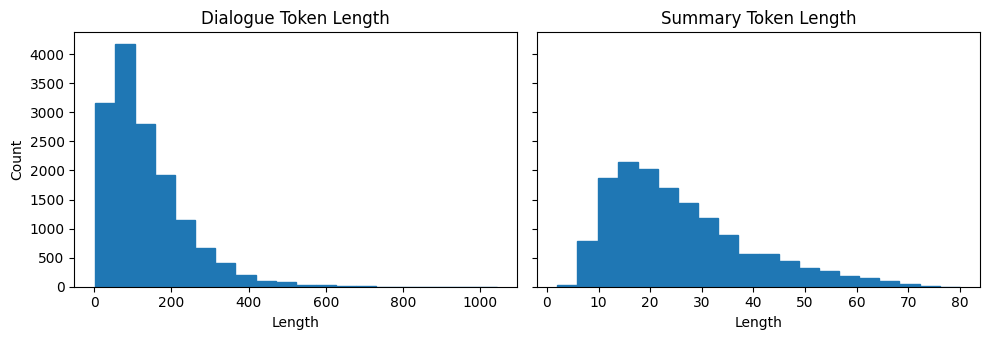

In [32]:
# Fine tune PEGASUS
# before we process the data, let's look at it in more detail

import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(d)) for d in dataset_samsum['train']['dialogue']]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary']]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [34]:
# We see that most dialogues are shorter than the CNN/DailyMail articles

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'], max_length=1024, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length=128, truncation=True)
    return { "input_ids": input_encodings['input_ids'], "attention_mask": input_encodings['attention_mask'],"labels": target_encodings['input_ids']}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ['input_ids', 'labels', 'attention_mask']
dataset_samsum_pt.set_format(type='torch', columns=columns)

# Now we need to create the data collator. This function is called in the Trainer just before the batch is fed through the model.

from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="pegasus-samsun", num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

from huggingface_hub import notebook_login

notebook_login()

trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt['train'],
                  eval_dataset=dataset_samsum_pt['validation'])

trainer.train()


score = evaluate_summaries_pegasus(dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size=2, column_text="dialogue", column_summary="summary")
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/home/nurbot/miniconda3/envs/hf/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/920 [00:00<?, ?it/s]

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 3.0895, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.134, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 2.8556, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 2.8926, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.8814, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.7581, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.74, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.57, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.5746, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.3925, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.2774, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.3161, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.0669, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1434, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 1.9236, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 2.0942, 'learning_ra

  0%|          | 0/818 [00:00<?, ?it/s]

{'eval_loss': 1.4860057830810547, 'eval_runtime': 15.1004, 'eval_samples_per_second': 54.171, 'eval_steps_per_second': 54.171, 'epoch': 0.54}
{'loss': 1.6404, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 1.6707, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 1.6771, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 1.6169, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 1.673, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 1.6017, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 1.5805, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 1.6918, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 1.5781, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.64}
{'loss': 1.6512, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.65}
{'loss': 1.6213, 'learning_rate': 3.690476190476191e-05, 'epoch': 0.66}
{'loss': 1.6488, 'learning_rate': 3.571428571428572e-05, 'epoch': 0

100%|██████████| 410/410 [04:05<00:00,  1.67it/s]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.430382,0.195261,0.337435,0.337575


In [36]:
# Generating dialogue summaries

gen_kwargs = { "length_penalty": 0.8, "max_length": 128, "num_beams": 8}
sample_text = dataset_samsum['test'][0]['dialogue']
reference = dataset_samsum['test'][0]['summary']
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:\n")
print(sample_text)
print("\nReference summary:")
print(reference)
print("\nModel summary:")
print(pipe(sample_text, **gen_kwargs)[0]['summary_text'])


# custom input?

custom_dialogue = """\
Thom: Hi guys, have you heard of Transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by huggingface.
Thom: I know, I helped build it :)
Lewis: That's awesome! Maybe we can write a book about it. What do you think?
Leandro: That's a great idea! We can call it Transformers Book.
Thom: Nice! Let's do it!
Lewis: Awesome! let's do it together.
"""

print(pipe(custom_dialogue, **gen_kwargs)[0]['summary_text'])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:

Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model summary:


Your max_length is set to 128, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.
Thom, Lewis and Leandro are going to write a book about Transformers. They are going to call it Transformers Book. Lewis, Leandro and Thom are going to do it together.
